### Laboratorium 9 - zadania

Rozpakuj dołączone archiwum `dataset.zip` w folderze z notebookiem przed rozpoczęciem pracy.  
Potrzebne Ci będą pakiety `scikit-learn` i `scikit-image` - doinstaluj, jeśli jeszcze nie posiadasz.

Na tym laboratorium przetestujesz uproszczoną wersję detektora Violi-Jonesa dla obrazów twarzy. Uproszczenie polegało będzie na tym, że nie będziemy stosować pełnego pipeline'u kaskadowego, gdyż jego nauczenie jest dość skomplikowanym i długotrwałym procesem. Zastosowanie takiego gotowego detektora jest banalnie proste, dlatego internet roi się od lepszych i gorszych tutoriali. Dobre przykłady znajdziesz w dokumentacji [scikit-image](https://scikit-image.org/docs/dev/auto_examples/applications/plot_face_detection.html) oraz [OpenCV](https://docs.opencv.org/4.5.4/db/d28/tutorial_cascade_classifier.html) - na obu stronach znajdziesz także pliki konfiguracyjne dla nauczonych detektorów.

Funkcje (linki do dokumentacji), które należy mieć pod ręką na tym laboratorium:
* [`skimage.transform.integral_image`](https://scikit-image.org/docs/dev/api/skimage.transform.html?highlight=integral_image#skimage.transform.integral_image)
* [`skimage.feature.haar_like_feature`](https://scikit-image.org/docs/stable/api/skimage.feature.html#haar-like-feature) - oblicza (opcjonalnie: wybrane) cechy Haara dla podanego obrazu całkowego
* [`skimage.feature.haar_like_feature_coord`](https://scikit-image.org/docs/stable/api/skimage.feature.html#haar-like-feature-coord) - wylicza koordynaty cech Haara
* [`skimage.feature.draw_haar_like_feature`](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.draw_haar_like_feature) - rysuje cechy Haara o podanych koordynatach
* [`sklearn.ensemble.AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

Przykładów użycia nie zamieszczam w instrukcji bo są świetne w dokumentacji.

In [52]:
import os
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import integral_image
from skimage.feature import haar_like_feature, haar_like_feature_coord, draw_haar_like_feature
from sklearn.ensemble import AdaBoostClassifier
import sklearn.tree
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Poniższa komórka wczyta cały dataset w postaci pary (lista obrazów, lista etykiet). Obrazy skonwertuje od razu do skali szarości, ale skalowanie musisz wykonać własnoręcznie.

In [37]:
def read_folder(path):
    return list(cv2.imread(item.path, flags=cv2.IMREAD_GRAYSCALE) for item in os.scandir(path))

positive_images = read_folder('natural_images_postprocessed/face')
negative_images = read_folder('natural_images_postprocessed/noface')

raw_images = positive_images + negative_images
raw_targets = np.asarray(list(1 for _ in positive_images ) + list(0 for _ in negative_images), dtype=np.int64)

Poniższa komórka ładuje obrazy testowe do części badawczej.

In [38]:
test_images = read_folder('test_images')

---

#### Zadanie 1 (0.5 pkt | 0.0 pkt)

Celem tego zadania jest nauczenie się korzystania z `haar_like_feature` i `haar_like_feature_coord`.

##### Zadanie 1a

Przetestuj pipeline do ekstrakcji cech Haara dla pojedynczego obrazu. Pamiętaj o skalowaniu! Sprawdź, ile cech otrzymujesz dla różnych skal pomiędzy 16x16 a 32x32. Zwróć uwagę, że `haar_like_feature` domyślnie ekstrahuje wszystkie możliwe cechy - być może wystarczą tylko niektóre z nich (np. tylko `type-2-x` i `type-2-y`).

In [39]:
img = test_images[0]
img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_LINEAR)
img = integral_image(img)

features = haar_like_feature(img, 0, 0, 32, 32, feature_type=['type-2-x', 'type-2-y'])
print(features)
print(features.shape)
# plt.imshow(img)

[ 7 14 18 ...  3  4  1]
(269824,)


##### Zadanie 1b 

Użyj `haar_like_feature_coord` do wyznaczenia koordynat cech Haara dla podanej konfiguracji (rozmiar obrazka, wybrane typy cech). Wartości zwracane przez tę funkcję to para (coords, types) w nieco dziwnym typie:
* coords to `np.array` o długości N=liczba cech, zawierający pythonowe listy dwuelementowe, zawierające punkty początkowy i końcowy prostokąta obejmującego daną cechę,
* types to `np.array` o długości N=liczba cech, zawierający stringi identyfikujące typ danej cechy.

Wybierz jedną dowolną cechę (na chybił trafił) i wyświetl ją używając `draw_haar_like_feature`.

['type-2-x' 'type-2-x' 'type-2-x' ... 'type-2-y' 'type-2-y' 'type-2-y']
[        -1         -1       -888 ... -743945644      10884  743956528]
(269824,)


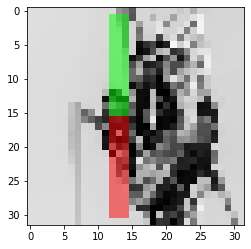

In [46]:
img_raw = test_images[1]
img_scaled = cv2.resize(img_raw, (32, 32), interpolation = cv2.INTER_LINEAR)
img_int = integral_image(img_scaled)

feature_coord, feature_type = haar_like_feature_coord(img_int.shape[0], img_int.shape[1], feature_type=['type-2-x', 'type-2-y'])
features = haar_like_feature(img_int, 0, 0, 5, 5, feature_type=feature_type, feature_coord=feature_coord)
print(features)
print(features.shape)

img_features = draw_haar_like_feature(img_scaled, 0, 0, 5, 5, feature_coord=feature_coord, max_n_features=1)
plt.imshow(img_features)

---

#### Zadanie 2 (0.75 pkt | 0.25 pkt)

Dokonaj ekstrakcji cech Haara z całego datasetu. Dobierz parametry (skalowanie, typy cech) w taki sposób, by ekstrakcja nie trwała więcej niż 2-5 minut. Uformuj zbiory uczący i walidacyjny na potrzeby uczenia klasyfikatora, pamiętając o losowym samplowaniu z obu klas (np. używając [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)).
Wykonaj uczenie klasyfikatora AdaBoost na tym zbiorze, zaczynając od niewielkiej liczby korzeni (N=10), powtarzając 2-3 razy dla większych wartości - ten proces również nie powinien trwać dłużej niż minutę. Na każdym etapie sprawdź, które cechy zostały wybrane.

In [69]:
classifier = AdaBoostClassifier(n_estimators=10)

In [59]:
def extract_features(images, size=(32,32), feature_type=['type-2-x', 'type-2-y']):
    feature_coord, feature_type = haar_like_feature_coord(size[0], size[1], feature_type=feature_type)
    features = []

    for img in tqdm(images):
        img = cv2.resize(img, size, interpolation = cv2.INTER_LINEAR)
        img = integral_image(img)
        haar_features = haar_like_feature(img, 0, 0, size[0], size[1], feature_type=feature_type, feature_coord=feature_coord)
        features.append(haar_features)
    
    return features

In [64]:
extracted_features = extract_features(raw_images, size=(24,24))

100%|██████████| 1976/1976 [01:17<00:00, 25.36it/s]


In [65]:
X_train, X_val, y_train, y_val = train_test_split(extracted_features, raw_targets, train_size=0.8, shuffle=True)

AdaBoostClassifier(n_estimators=3)

In [70]:
classifier.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=10)

In [71]:
classifier.score(X_val, y_val)

0.9722222222222222

Poszczególne składniki klasyfikatora znajdują się w atrybucie `estimators_` (tworzonym dopiero po sfitowaniu). Aby dobrać się do konkretnych drzew (korzeni) decyzyjnych:

In [72]:
for tree_id in range(classifier.n_estimators):
    my_tree = classifier.estimators_[tree_id].tree_ # konkretne drzewo (korzeń) -- NIE ZADZIAŁA PRZED NAUCZENIEM
    print(my_tree.feature)   # cecha skojarzona z korzeniem; zwróć uwagę, że tylko pierwszy element zawiera id konkretnej cechy
    print(my_tree.threshold) # próg decyzyjny dla tej cechy
    print(sklearn.tree.export_text(classifier.estimators_[tree_id])) # pretty-printing powyższego, obiekt musi mieć atrybut 'tree_'

[70399    -2    -2]
[130.5  -2.   -2. ]
|--- feature_70399 <= 130.50
|   |--- class: 0
|--- feature_70399 >  130.50
|   |--- class: 1

[22535    -2    -2]
[76.5 -2.  -2. ]
|--- feature_22535 <= 76.50
|   |--- class: 0
|--- feature_22535 >  76.50
|   |--- class: 1

[63781    -2    -2]
[-18.5  -2.   -2. ]
|--- feature_63781 <= -18.50
|   |--- class: 1
|--- feature_63781 >  -18.50
|   |--- class: 0

[71155    -2    -2]
[ 3.5 -2.  -2. ]
|--- feature_71155 <= 3.50
|   |--- class: 0
|--- feature_71155 >  3.50
|   |--- class: 1

[15013    -2    -2]
[-87.5  -2.   -2. ]
|--- feature_15013 <= -87.50
|   |--- class: 1
|--- feature_15013 >  -87.50
|   |--- class: 0

[1351   -2   -2]
[254.5  -2.   -2. ]
|--- feature_1351 <= 254.50
|   |--- class: 0
|--- feature_1351 >  254.50
|   |--- class: 1

[68296    -2    -2]
[15.5 -2.  -2. ]
|--- feature_68296 <= 15.50
|   |--- class: 0
|--- feature_68296 >  15.50
|   |--- class: 1

[69089    -2    -2]
[62.5 -2.  -2. ]
|--- feature_69089 <= 62.50
|   |--- cla

---

#### Zadanie 3 (1.0 pkt | 0.25 pkt)

Dla wybranego obrazu testowego wykonaj inferencję wykorzystując podejście *sliding-sindow*:
* przeskaluj obraz źródłowy (możesz założyć a priori, że wiadomo jakiego rozmiaru będą twarze),
* oblicz obraz całkowy,
* dla każdego RoI wykonaj ekstrakcję cech Haara...
* ...a następnie ich klasyfikację;
* jeśli jest pozytywna - zapisz koordynaty danego RoI.

Do prezentacji wyników możesz wykorzystać [`cv2.rectangle`](https://docs.opencv.org/4.5.4/d6/d6e/group__imgproc__draw.html#ga07d2f74cadcf8e305e810ce8eed13bc9) (przeskaluj wymiary znalezionego RoI w górę, by narysować bounding-boksa na obrazie oryginalnym).

In [ ]:
test_img = test_images[5]
test_img_int = integral_image(test_img)
size = (24,24)
feature_coord, feature_type = haar_like_feature_coord(size[0], size[1], feature_type=['type-2-x', 'type-2-y'])
for y in range(test_img_int.shape[0] - size[0]):
    for x in range(test_img_int.shape[1] - size[1]):
        feature = haar_like_feature(test_img_int, x, y, size[0])

---

#### Zadanie 4 (0.75 pkt | 0.0 pkt)

Dokonaj optymalizacji algorytmu detekcji cech.

##### Zadanie 4a (0.25 pkt)

Ze znalezionych korzeni decyzyjnych łatwo wyciągniesz indeksy cech znaczących - wykorzystaj je oraz funkcję `haar_like_feature_coord` do znalezienia podzbioru koordynat cech Haara, które następnie przekażesz do funkcji `haar_like_feature` jako parę opcjonalnych parametrów `feature_type` i `feature_coord`. Sprawdź, o ile szybciej działa teraz ekstraktor.

##### Zadanie 4b (0.5 pkt)

Zmodyfikuj swój klasyfikator tak, aby korzystał ze zredukowanego zbioru cech. Proponowane rozwiązania:
* (a) zmień parametr `features` w każdym z drzew, tak aby nie szukały cech w oryginalnym wektorze, a w zredukowanym,
* (b) nie zmieniaj klasyfikatora, a zamiast tego mapuj zredukowane cechy do wektora o oryginalnej długości.

Przetestuj cały pipeline na obrazach testowych.

---

#### Zadanie 5 (0.0 pkt | 1.0 pkt)

Wykonaj testy jakości detekcji dla klasyfikatorów o różnej liczbie cech. Wyniki omów, komentując mocne i słabe strony metody - ilościowe miary jakości nie są istotne (m.in. z tego powodu zbiór testowy jest tak niewielki i nie ma etykiet).

Wykonaj testy wydajnościowe różnych klasyfikatorów. Dla porównania uwzględnij przynajmniej jeden przed optymalizacją ekstrakcji cech. Wyniki przedstaw w formie tabeli, mierząc średni czas przetwarzania jednego obrazu.

#### Zadanie 6 (0.0 pkt | 0.5 pkt)

Wykorzystaj dowolny znaleziony w internecie model głębokiej sieci neuronowej do detekcji twarzy, np. [https://github.com/timesler/facenet-pytorch](https://github.com/timesler/facenet-pytorch), porównując jego działanie z uzyskanymi w trakcie laboratorium klasyfikatorami pod względem jakości detekcji i szybkości działania.